In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 11.1 MB/s eta 0:00:00


In [3]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.5 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import re
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, KFold
import optuna
import pickle

In [5]:
columns = ["Country", "City", "State", "Neighbourhood Cleansed", "Host Since", "Host Response Time", "Host Response Rate", "Calculated host listings count", "Property Type", "Room Type", "Accommodates", "Bedrooms", "Beds", "Bed Type", "Square Feet", "Cancellation Policy", "Minimum Nights", "Maximum Nights", "Has Availability", "Availability 30", "Availability 60", "Availability 90", "Availability 365", "Number of Reviews", "Reviews per Month", "First Review", "Last Review", "Review Scores Rating", "Review Scores Accuracy", "Review Scores Cleanliness", "Review Scores Checkin", "Review Scores Communication", "Review Scores Location", "Review Scores Value", "Features", "Amenities", "Price"]

features_new_host = ["Country", "City", "Neighbourhood Cleansed", "Property Type", "Room Type", "Accommodates", "Bedrooms", "Beds", "Bed Type", "Cancellation Policy", "Minimum Nights", "Price"]

features_existing_host = ["Country", "City", "Neighbourhood Cleansed", "Property Type", "Room Type", "Accommodates", "Bedrooms", "Beds", "Bed Type", "Cancellation Policy", "Minimum Nights", "Availability 30", "Availability 60", "Availability 90", "Availability 365", "Number of Reviews", "Reviews per Month", "Review Scores Rating", "Review Scores Accuracy", "Review Scores Cleanliness", "Review Scores Checkin", "Review Scores Communication", "Review Scores Location", "Review Scores Value", "Host Since", "Host Response Time", "Host Response Rate", "Calculated host listings count", "Price"]

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/airbnb-listings.csv',  usecols=columns, sep=';')

In [7]:
df.head()

,Host Since,Host Response Time,Host Response Rate,Neighbourhood Cleansed,City,State,Country,Property Type,Room Type,Accommodates,...,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Calculated host listings count,Reviews per Month,Features
0,2016-05-24,within an hour,100.0,Williamsburg,Brooklyn,NY,United States,Loft,Private room,1.0,...,9.0,8.0,9.0,9.0,9.0,9.0,flexible,6.0,2.93,Host Has Profile Pic
1,2012-09-24,within a few hours,100.0,BYRON SHIRE COUNCIL,Byron Bay,NSW,Australia,House,Entire home/apt,4.0,...,10.0,10.0,10.0,10.0,10.0,10.0,strict,1.0,0.24,"Host Has Profile Pic,Host Identity Verified,Is..."
2,2014-03-04,within an hour,100.0,BYRON SHIRE COUNCIL,Suffolk Park,NSW,Australia,Apartment,Entire home/apt,3.0,...,10.0,10.0,9.0,9.0,9.0,9.0,strict,2.0,4.00,"Host Has Profile Pic,Host Identity Verified,Is..."
3,2010-11-28,within an hour,100.0,BYRON SHIRE COUNCIL,Bangalow,NSW,Australia,Cabin,Entire home/apt,2.0,...,10.0,10.0,10.0,10.0,9.0,9.0,strict,1.0,0.83,"Host Has Profile Pic,Host Identity Verified,Is..."
4,2014-03-12,a few days or more,43.0,BYRON SHIRE COUNCIL,Suffolk Park,NSW,Australia,House,Entire home/apt,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,flexible,2.0,NaN,"Host Has Profile Pic,Is Location Exact"


In [8]:
# Checking the number of rows and columns

num_rows, num_columns = df.shape

print("Shape of the Data:")
print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}\n")

Shape of the Data:
Number of Rows: 494954
Number of Columns: 37



In [9]:
# Creating a table for missing values, unique values and data types of the features

missing_values = pd.DataFrame({'Feature': df.columns,
                              'No. of Missing Values': df.isnull().sum().values,
                              '% of Missing Values': ((df.isnull().sum().values)/len(df)*100)})

unique_values = pd.DataFrame({'Feature': df.columns,
                              'No. of Unique Values': df.nunique().values})

feature_types = pd.DataFrame({'Feature': df.columns,
                              'DataType': df.dtypes})

example = pd.DataFrame({'Feature': df.columns,
                        'Example Value': df.iloc[0]})

data_info = pd.merge(missing_values, unique_values, on='Feature', how='left')
data_info = pd.merge(data_info, feature_types, on='Feature', how='left')
data_info = pd.merge(data_info, example, on='Feature', how='left')

data_info

,Feature,No. of Missing Values,% of Missing Values,No. of Unique Values,DataType,Example Value
0,Host Since,505,0.102030,3129,object,2016-05-24
1,Host Response Time,115069,23.248423,5,object,within an hour
2,Host Response Rate,115070,23.248625,99,float64,100.0
3,Neighbourhood Cleansed,1,0.000202,2379,object,Williamsburg
4,City,454,0.091726,5532,object,Brooklyn
5,State,49794,10.060329,1823,object,NY
6,Country,3,0.000606,23,object,United States
7,Property Type,11,0.002222,45,object,Loft
8,Room Type,1,0.000202,4,object,Private room
9,Accommodates,63,0.012728,20,float64,1.0


In [10]:
duplicates = df.duplicated().sum()

print(f"Number of duplicate rows : {duplicates}")

Number of duplicate rows : 357


In [11]:
# Having a look at the description of all the numerical columns present in the dataset

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Host Response Rate,379884.0,93.376549,1.759244e+01,0.00,98.00,100.00,100.00,1.000000e+02
Accommodates,494891.0,3.311584,2.094052e+00,1.00,2.00,2.00,4.00,2.100000e+01
Bedrooms,494328.0,1.378322,9.425079e-01,0.00,1.00,1.00,2.00,9.600000e+01
Beds,494037.0,1.934525,1.488128e+00,0.00,1.00,1.00,2.00,1.900000e+01
Square Feet,12209.0,575.544762,1.825903e+03,0.00,0.00,377.00,800.00,1.291670e+05
Price,486996.0,138.072703,1.496705e+02,0.00,55.00,90.00,150.00,9.990000e+02
Minimum Nights,494952.0,3.470415,8.939636e+01,1.00,1.00,2.00,3.00,6.000000e+04
Maximum Nights,494952.0,212340.601452,2.024385e+07,1.00,32.00,1125.00,1125.00,2.147484e+09
Availability 30,494952.0,9.961726,1.098109e+01,0.00,0.00,5.00,19.00,3.000000e+01
Availability 60,494952.0,22.997256,2.235110e+01,0.00,0.00,17.00,44.00,6.000000e+01


# Data Cleaning

### -> 'Price' Feature

In [12]:
# Group by "Host Response Time" and count the number of instances in each Host Response Time
null_price_count = df['Price'].isnull().sum()

print(f'Null Price Instances {null_price_count}')

Null Price Instances 7958


In [13]:
# Drop all rows with null price
df = df.dropna(subset=['Price'])

# Check the number of instances after removal
print(f'Number of instances after removing small cities: {len(df)}')

Number of instances after removing small cities: 486996


### -> 'Country' Feature

In [14]:
# Group by "Country" and count the number of instances in each country
country_counts = df.groupby('Country').size()
null_country_count = df['Country'].isnull().sum()

# Display the result
print(f'Countries with their number of instances : ')
print(country_counts)
print('------------------------------------------')
print(f'Null Country Instances {null_country_count}')

Countries with their number of instances : 
Country
0                      1
Australia          40219
Austria             7889
Belgium             7415
Canada             30692
China                 50
Cuba                   1
Denmark            16569
France             56505
Germany            20568
Greece              5122
Hong Kong           5301
Ireland             6724
Italy              33110
Mexico                 2
Netherlands        15173
Spain              45732
Switzerland         2370
United Kingdom     60966
United States     132581
Uruguay                1
Vanuatu                1
Vatican City           2
dtype: int64
------------------------------------------
Null Country Instances 2


In [15]:
low_count_countries_list = ['0', 'Cuba', 'Mexico', 'Uruguay', 'Vanuatu', 'Vatican City', 'China']

# Filter out null instances rows with countries in low_count_countries_list
df = df[~df['Country'].isin(low_count_countries_list)]
df = df.dropna(subset=['Country'])

# Check the number of instances after removal
print(f'Number of instances after removing small cities: {len(df)}')

Number of instances after removing small cities: 486936


### -> 'City' Feature

In [16]:
# Group by "City" and count the number of instances in each City
city_counts = df.groupby('City').size()
small_city_counts = city_counts[city_counts < 10]
null_city_count = df['City'].isnull().sum()

# Display the result
print(f'Cities with less than 10 instances ({len(small_city_counts)} Number of Cities out of {len(city_counts)}): ')
print(small_city_counts)
print('------------------------------------------')
print(f'Null Country Instances {null_city_count}')

Cities with less than 10 instances (4268 Number of Cities out of 5447): 
City
-                 2
0\n0              1
00165             1
07310 Campanet    1
07330             1
                 ..
치펀데일              1
킹스턴 어폰 세임스        1
토론토               9
파리                1
홍콩                2
Length: 4268, dtype: int64
------------------------------------------
Null Country Instances 417


In [17]:
# Get the list of small cities
small_cities = small_city_counts.index.tolist()

# Remove instances belonging to small cities
df = df[~df['City'].isin(small_cities)]
df = df.dropna(subset=['City'])

# Check the number of instances after removal
print(f'Number of instances after removing small cities: {len(df)}')

Number of instances after removing small cities: 477450


### -> 'Neighbourhood Cleansed' Feature

In [18]:
# Group by "City" and count the number of instances in each City
neighbourhood_counts = df.groupby('Neighbourhood Cleansed').size()
small_neighbourhood_counts = neighbourhood_counts[neighbourhood_counts < 10]
null_neighbourhood_counts = df['City'].isnull().sum()
neighborhood_starts_with_7 = df[df['Neighbourhood Cleansed'].str.startswith('7')]

print('Neighborhoods that starts with 7:')
print(neighborhood_starts_with_7['Neighbourhood Cleansed'].unique())
# Display the result
print('------------------------------------------')
print(f'Cities with less than 10 instances ({len(small_neighbourhood_counts)} Number of Neighbourhoods out of {len(neighbourhood_counts)}): ')
print(small_neighbourhood_counts)
print('------------------------------------------')
print(f'Null Country Instances {null_neighbourhood_counts}')

Neighborhoods that starts with 7:
['78704' '78758' '78757' '78744' '78741' '78705' '78703' '78756' '78751'
 '78723' '78702' '78701' '78745' '78748' '78753' '78752' '78727' '78754'
 '78732' '78749' '78736' '78722' '78746' '78734' '78733' '78721' '78728'
 '78731' '78750' '78735' '78738' '78729' '78759' '78747' '78724' '78737'
 '78730' '78739' '78725' '78717' '78726' '78712' '78719' '78742']
------------------------------------------
Cities with less than 10 instances (515 Number of Neighbourhoods out of 2331): 
Neighbourhood Cleansed
78712                         2
78719                         6
78742                         2
Acorn-Acorn Industrial        2
Acton                         1
                             ..
la Marina del Prat Vermell    6
la Trinitat Nova              7
la Trinitat Vella             6
ΚΟΛΟΚΥΝΘΟΥ                    6
ΡΗΓΙΛΛΗΣ                      9
Length: 515, dtype: int64
------------------------------------------
Null Country Instances 0


In [19]:
# Filter the DataFrame
df = df[~((df['Neighbourhood Cleansed'].str.startswith('7')) |
                   (df['Neighbourhood Cleansed'].isnull()) |
                   (df['Neighbourhood Cleansed'].isin(small_neighbourhood_counts.index)))]

print(f'Number of instances after removing small cities: {len(df)}')

Number of instances after removing small cities: 465927


### -> 'Property Type' Feature

In [20]:
# Group by "Property Type" and count the number of instances in each Property Type
property_type_counts = df.groupby('Property Type').size()
small_property_type_counts = property_type_counts[property_type_counts < 10]
null_property_type_count = df['Property Type'].isnull().sum()

# Display the result
print(f'Property Types with less than 10 instances ({len(small_property_type_counts)} Number of Property Types out of {len(property_type_counts)}): ')
print(small_property_type_counts)
print('------------------------------------------')
print(f'Null Property Types Instances {null_property_type_count}')

Property Types with less than 10 instances (12 Number of Property Types out of 44): 
Property Type
Car                       1
Casa particular           9
Heritage hotel (India)    1
Igloo                     5
Island                    6
Lighthouse                8
Parking Space             4
Pension (Korea)           2
Plane                     1
Ryokan (Japan)            2
Train                     7
Van                       1
dtype: int64
------------------------------------------
Null Property Types Instances 10


In [21]:
# Get the list of small Property Types
small_property_type = small_property_type_counts.index.tolist()

# Remove instances belonging to small Property Types
df = df[~df['Property Type'].isin(small_property_type)]
df = df.dropna(subset=['Property Type'])

# Check the number of instances after removal
print(f'Number of instances after removing small Property Types: {len(df)}')

Number of instances after removing small Property Types: 465870


### -> 'Room Type' Feature

In [22]:
null_room_type_count = df['Room Type'].isnull().sum()

# Display the result
print(f'Null Room Type Instances {null_room_type_count}')

Null Room Type Instances 0


### -> 'Accommodates' Feature

In [23]:
null_cccommodates_count = df['Accommodates'].isnull().sum()

# Display the result
print(f'Null Accommodates Instances {null_cccommodates_count}')

Null Accommodates Instances 57


In [24]:
df = df.dropna(subset=['Accommodates'])
df = df[df["Accommodates"] <= 16]

# Check the number of instances after removal
print(f'Number of instances after removing small Property Types: {len(df)}')

Number of instances after removing small Property Types: 465811


### -> 'Bedrooms' Feature

In [25]:
# Group by 'Bedrooms' and count the number of instances in each Bedroom
bedrooms_counts = df.groupby('Bedrooms').size()
null_bedrooms_count = df['Bedrooms'].isnull().sum()

# Display the result
print(f'Bedrooms with their number of instances : ')
print(bedrooms_counts)
print('------------------------------------------')
print(f'Null Bedrooms Instances {null_bedrooms_count}')

Bedrooms with their number of instances : 
Bedrooms
0.0      35893
1.0     299243
2.0      84023
3.0      31380
4.0      10733
5.0       2705
6.0        797
7.0        201
8.0         94
9.0         45
10.0        92
dtype: int64
------------------------------------------
Null Bedrooms Instances 605


In [26]:
# Replace missing values in 'Bedrooms' column with mode
df['Bedrooms'].fillna(df['Bedrooms'].mode()[0], inplace=True)

### -> 'Beds' Feature

In [27]:
# Group by 'Beds' and count the number of instances in each Bed
beds_counts = df.groupby('Beds').size()
null_beds_count = df['Beds'].isnull().sum()

# Display the result
print(f'Beds with their number of instances : ')
print(beds_counts)
print('------------------------------------------')
print(f'Null Beds Instances {null_beds_count}')

Beds with their number of instances : 
Beds
0.0         26
1.0     253451
2.0     115637
3.0      45519
4.0      25684
5.0      11007
6.0       6793
7.0       2394
8.0       2003
9.0        634
10.0       789
11.0       190
12.0       280
13.0        72
14.0       113
15.0        51
16.0       318
19.0         1
dtype: int64
------------------------------------------
Null Beds Instances 849


In [28]:
low_count_beds_list = [19.0]

# Filter out null instances rows with beds in low_count_beds_list
df = df[~df['Beds'].isin(low_count_beds_list)]
df = df.dropna(subset=['Beds'])

# Check the number of instances after removal
print(f'Number of instances after removing small cities: {len(df)}')

Number of instances after removing small cities: 464961


### -> 'Bed Type' Feature

In [29]:
# Group by 'Bed Type' and count the number of instances in each Bed Type
bed_type_counts = df.groupby('Bed Type').size()
null_bed_type_count = df['Bed Type'].isnull().sum()

# Display the result
print(f'Beds with their number of instances : ')
print(bed_type_counts)
print('------------------------------------------')
print(f'Null Beds Instances {null_bed_type_count}')

Beds with their number of instances : 
Bed Type
Airbed             1183
Couch              1937
Futon              3412
Pull-out Sofa      9540
Real Bed         448889
dtype: int64
------------------------------------------
Null Beds Instances 0


### -> 'Cancellation Policy' Feature

In [30]:
# Group by "Cancellation Policy" and count the number of instances in each Cancellation Policy Type
cancellation_policy_type_counts = df.groupby('Cancellation Policy').size()
small_cancellation_policy_type_counts = cancellation_policy_type_counts[cancellation_policy_type_counts < 10]
null_cancellation_policy_type_count = df['Cancellation Policy'].isnull().sum()

# Display the result
print(f'Cancellation Policy with their number of instances : ')
print(cancellation_policy_type_counts)
print('------------------------------------------')
print(f'Null Cancellation Policy Types Instances {null_cancellation_policy_type_count}')

Cancellation Policy with their number of instances : 
Cancellation Policy
flexible               145227
flexible_new             9180
long_term                   2
moderate               115480
moderate_new            11534
no_refunds                  6
strict                 171568
strict_new               9941
super_strict_30           840
super_strict_30_new        41
super_strict_60          1120
super_strict_60_new        22
dtype: int64
------------------------------------------
Null Cancellation Policy Types Instances 0


In [31]:
# Get the list of small Cancellation Policy Types
small_cancellation_policy_type = small_cancellation_policy_type_counts.index.tolist()

# Remove instances belonging to small Cancellation Policy Types
df = df[~df['Cancellation Policy'].isin(small_cancellation_policy_type)]
df = df.dropna(subset=['Cancellation Policy'])

# Check the number of instances after removal
print(f'Number of instances after removing small Cancellation Policy Types: {len(df)}')

Number of instances after removing small Cancellation Policy Types: 464953


### -> 'Minimum Nights' Feature

In [32]:
# Group by "Minimum Nights" and count the number of instances in each Minimum Nights Type
minimum_nights_type_counts = df.groupby('Minimum Nights').size()
null_minimum_nights_type_count = df['Minimum Nights'].isnull().sum()

# Display the result
print(f'Minimum Nights with their number of instances : ')
print(minimum_nights_type_counts)
print('------------------------------------------')
print(f'Null Minimum Nights Types Instances {null_minimum_nights_type_count}')

Minimum Nights with their number of instances : 
Minimum Nights
1.0        161471
2.0        134977
3.0         79906
4.0         24041
5.0         22218
            ...  
5000.0          2
6000.0          1
9999.0          1
10000.0         1
60000.0         1
Length: 144, dtype: int64
------------------------------------------
Null Minimum Nights Types Instances 0


In [33]:
# Remove "Minimum Nights" above 30 except for multiples of 30 (corresponding to months)
df = df[(df["Minimum Nights"]<=31) | (df["Minimum Nights"].isin([60, 90, 120, 180]))]

# Check the number of instances after removal
print(f'Number of instances after removing small cities: {len(df)}')

Number of instances after removing small cities: 464134


### -> 'Availability' Features

In [34]:
null_availability_30_count = df['Availability 30'].isnull().sum()
null_availability_60_count = df['Availability 60'].isnull().sum()
null_availability_90_count = df['Availability 90'].isnull().sum()
null_availability_365_count = df['Availability 365'].isnull().sum()
df.drop(columns=['Has Availability'], inplace=True)

print(f'Null Availability 30 Instances {null_availability_30_count}')
print(f'Null Availability 60 Instances {null_availability_60_count}')
print(f'Null Availability 90 Instances {null_availability_90_count}')
print(f'Null Availability 365 Instances {null_availability_365_count}')

Null Availability 30 Instances 0
Null Availability 60 Instances 0
Null Availability 90 Instances 0
Null Availability 365 Instances 0


### -> 'Number of Reviews' Feature

In [35]:
null_number_of_reviews_count = df['Number of Reviews'].isnull().sum()
zero_number_of_reviews_count = df[df["Number of Reviews"] == 0]["Number of Reviews"].count()

print(f'Null Number of Reviews Instances {null_number_of_reviews_count}')
print(f'Zero Number of Reviews Instances {zero_number_of_reviews_count}')

Null Number of Reviews Instances 0
Zero Number of Reviews Instances 110905


In [36]:
df = df[df["Number of Reviews"] > 0]
df.drop(columns=['First Review'], inplace=True)
df.drop(columns=['Last Review'], inplace=True)

# Check the number of instances after removal
print(f'Number of instances after removing small cities: {len(df)}')

Number of instances after removing small cities: 353229


<ipython-input-36-a9a9a8db70ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['First Review'], inplace=True)
<ipython-input-36-a9a9a8db70ab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Last Review'], inplace=True)


### -> 'Reviews per Month' Feature

In [37]:
null_reviews_per_month_count = df['Reviews per Month'].isnull().sum()

print(f'Null Reviews per Month Instances {null_reviews_per_month_count}')

Null Reviews per Month Instances 221


In [38]:
df = df.dropna(subset=['Reviews per Month'])

# Check the number of instances after removal
print(f'Number of instances after removing small Cancellation Policy Types: {len(df)}')

Number of instances after removing small Cancellation Policy Types: 353008


### -> 'Reviews Scores' Features


In [39]:
reviews_scores_cols = ["Review Scores Rating", "Review Scores Accuracy", "Review Scores Cleanliness",
                 "Review Scores Checkin", "Review Scores Communication", "Review Scores Location",
                 "Review Scores Value"]

df = df.dropna(subset=reviews_scores_cols)

# Check the number of instances after removal
print(f'Number of instances after removing small Cancellation Policy Types: {len(df)}')

Number of instances after removing small Cancellation Policy Types: 345738


### -> 'Host Since' Features


In [40]:
null_host_since_count = df['Host Since'].isnull().sum()

print(f'Null Host Since Instances {null_host_since_count}')

Null Host Since Instances 271


In [41]:
df = df.dropna(subset=['Host Since'])

# Check the number of instances after removal
print(f'Number of instances after removing small Cancellation Policy Types: {len(df)}')

Number of instances after removing small Cancellation Policy Types: 345467


In [42]:
# Convert date to number of days till today
today_date = pd.to_datetime(pd.to_datetime("today").date())
df["Host Since"] = pd.to_datetime(df["Host Since"])
df["Host Since Days"] = (today_date - df["Host Since"])
df['Host Since Days'] = df[['Host Since Days']].apply(pd.to_numeric)
df['Host Since Days'] = df['Host Since Days'] / (24*60*60*1e9) #np.timedelta64(1, 'D')
df["Host Since Days"] = df["Host Since Days"].astype(int)

df.drop(columns=['Host Since'], inplace=True)

### -> 'Host Response Rate' Features

In [43]:
# Group by "Cancellation Policy" and count the number of instances in each Cancellation Policy Type
host_response_rate_mean = df['Host Response Rate'].mean()
null_host_response_rate_count = df['Host Response Rate'].isnull().sum()

# Display the result
print(f'Host Response Rate Mean : {host_response_rate_mean}')
print('------------------------------------------')
print(f'Null Host Response Rate Instances {null_host_response_rate_count}')

Host Response Rate Mean : 94.58278320299125
------------------------------------------
Null Host Response Rate Instances 53415


In [44]:
# Replace null instances with the mean value
df['Host Response Rate'].fillna(host_response_rate_mean, inplace=True)

### -> 'Host Response Time' Features

In [45]:
# Group by "Host Response Time" and count the number of instances in each Host Response Time
host_response_time_counts = df.groupby('Host Response Time').size()
null_host_response_time_count = df['Host Response Time'].isnull().sum()

# Display the result
print(f'Host Response Rate with their number of instances : ')
print(host_response_time_counts)
print('------------------------------------------')
print(f'Null Host Response Rate Instances {null_host_response_time_count}')

Host Response Rate with their number of instances : 
Host Response Time
a few days or more      6579
within a day           51916
within a few hours     74266
within an hour        159291
dtype: int64
------------------------------------------
Null Host Response Rate Instances 53415


In [46]:
# Replace null values in the "Host Response Time" column with "a few days or more"
df["Host Response Time"].fillna("a few days or more", inplace=True)

### -> 'Calculated host listings count' Features

In [47]:
# Group by "Calculated host listings count" and count the number of instances in each Calculated host listings count
host_listing_counts = df.groupby('Calculated host listings count').size()
null_host_listing_count = df['Calculated host listings count'].isnull().sum()

# Display the result
print(f'Host Response Rate with their number of instances : ')
print(host_listing_counts)
print('------------------------------------------')
print(f'Null Host Response Rate Instances {null_host_listing_count}')

Host Response Rate with their number of instances : 
Calculated host listings count
1.0      209191
2.0       50201
3.0       21866
4.0       11959
5.0        7680
          ...  
193.0        24
212.0        22
224.0         6
711.0       136
752.0       252
Length: 111, dtype: int64
------------------------------------------
Null Host Response Rate Instances 585


In [48]:
# Replace null values in the "Calculated host listings count" column with 1
df["Calculated host listings count"].fillna(1, inplace=True)

## Extracting Features from 'Features'

In [49]:
'''
features_list = []
for i in range(len(df["Features"].unique())):
    if not pd.isnull(df["Features"].unique()[i]):
        features = df["Features"].unique()[i].split(",")
        for ft in features:
            if ft not in features_list:
                features_list.append(ft)
'''

'\nfeatures_list = []\nfor i in range(len(df["Features"].unique())):\n    if not pd.isnull(df["Features"].unique()[i]):\n        features = df["Features"].unique()[i].split(",")\n        for ft in features:\n            if ft not in features_list:\n                features_list.append(ft)\n'

In [50]:
features_list = ['Host Has Profile Pic', 'Host Identity Verified', 'Is Location Exact', 'Instant Bookable', 'Requires License', 'Host Is Superhost', 'Require Guest Phone Verification', 'Require Guest Profile Picture']

In [51]:
# Initialize feature columns
for feature in features_list:
    df[feature] = 0

In [52]:
# Split the "Features" column by comma and create dummy variables for each feature
feature_dummies = df['Features'].str.get_dummies(sep=',')

# Update the DataFrame with the dummy variables
df.update(feature_dummies)

# Fill NaN values in newly created columns with 0
df[features_list] = df[features_list].fillna(0).astype(int)

df.drop(columns=['Features'], inplace=True)

## Extracting Amenities from 'Amenities'

In [53]:
'''
amenities_list = []
for i in range(len(df["Amenities"].unique())):
    if not pd.isnull(df["Amenities"].unique()[i]):
        amenities = df["Amenities"].unique()[i].split(",")
        for ft in amenities:
            if ft not in amenities_list:
                amenities_list.append(ft)
'''

'\namenities_list = []\nfor i in range(len(df["Amenities"].unique())):\n    if not pd.isnull(df["Amenities"].unique()[i]):\n        amenities = df["Amenities"].unique()[i].split(",")\n        for ft in amenities:\n            if ft not in amenities_list:\n                amenities_list.append(ft)\n'

In [54]:
amenities_list = ['TV', 'Wireless Internet', 'Kitchen', 'Heating', 'Family/kid friendly', 'Washer', 'Smoke detector', 'Fire extinguisher', 'Essentials', 'Cable TV', 'Internet', 'Dryer', 'First aid kit', 'Safety card', 'Shampoo', 'Hangers', 'Laptop friendly workspace', 'Air conditioning', 'Breakfast', 'Free parking on premises', 'Elevator in building', 'Buzzer/wireless intercom', 'Hair dryer', 'Private living room', 'Iron', 'Wheelchair accessible', 'Hot tub', 'Carbon monoxide detector', '24-hour check-in', 'Pets live on this property', 'Dog(s)', 'Gym', 'Lock on bedroom door', 'Private entrance', 'Indoor fireplace', 'Smoking allowed', 'Pets allowed', 'Cat(s)', 'Self Check-In', 'Doorman Entry', 'Suitable for events', 'Pool', 'Lockbox', 'Bathtub', 'Room-darkening shades', 'Game console', 'Doorman', 'High chair', 'Pack ’n Play/travel crib', 'Keypad', 'Other pet(s)', 'Smartlock']

In [55]:
# Initialize amenity columns
for amenity in amenities_list:
    df[amenity] = 0

# Assign values to amenity columns
# Split the "Amenities" column by comma and create dummy variables for each amenity
amenity_dummies = df['Amenities'].str.get_dummies(sep=',')
# Update the DataFrame with the dummy variables
df.update(amenity_dummies)

# Fill NaN values in newly created columns with 0
df[amenities_list] = df[amenities_list].fillna(0).astype(int)

df.drop(columns=['Amenities'], inplace=True)

In [56]:
null_price_count = df['Price'].isnull().sum()

print(f'Null Price Instances {null_price_count}')

Null Price Instances 0


## -> Converting Local Currency to GBP

In [57]:
# Define the updated currency conversion factors
currency_factors = {
    'Netherlands': 0.86,  # Euro to GBP
    'Germany': 0.86,      # Euro to GBP
    'Spain': 0.86,        # Euro to GBP
    'Greece': 0.86,       # Euro to GBP
    'Belgium': 0.86,      # Euro to GBP
    'Ireland': 0.86,      # Euro to GBP
    'Italy': 0.86,        # Euro to GBP
    'Austria': 0.86,      # Euro to GBP
    'France': 0.86,       # Euro to GBP
    'United States': 0.79,
    'Denmark': 0.12,      # Danish Krone to GBP
    'United Kingdom': 1.0,
    'Switzerland': 0.88,  # Swiss Franc to GBP
    'Hong Kong': 0.10,    # Hong Kong Dollar to GBP
    'Australia': 0.52,    # Australian Dollar to GBP
    'Canada': 0.58,       # Canadian Dollar to GBP
    'China': 0.11         # Chinese Yuan to GBP
}

# Update the currency conversion factor in the DataFrame
df['Local Currency to GBP Factor'] = df['Country'].map(currency_factors)

# Convert the final price to GBP
df['Price'] = df['Price'] * df['Local Currency to GBP Factor']

# Drop the intermediate column
df.drop(columns=["Local Currency to GBP Factor"], inplace=True)

# EDA

## How many listings are available in each City, Country, or Room Type?

In [58]:
numerical_variables = ['Host Response Rate', 'Accommodates', 'Bedrooms', 'Beds', 'Square Feet', 'Price', 'Number of Reviews', 'Host Since Days', 'Reviews per Month']
target_variables = []
categorical_variables = ['Host Response Time', 'City', 'State', 'Country', 'Property Type', 'Room Type', 'Bed Type', 'Amenities', 'Has Availability', 'Cancellation Policy', 'Features']

In [59]:
sns.set_style('whitegrid')
color_palette = 'viridis'

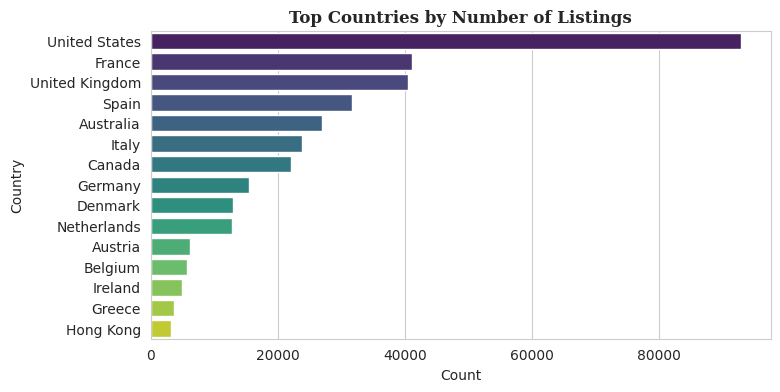

In [60]:
# Get the top 15 countries by count
top_countries = df['Country'].value_counts().head(15)

# Create a bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x=top_countries.values, y=top_countries.index, palette=color_palette, hue=top_countries.index, dodge=False, legend=False)

# Set labels and title
plt.xlabel('Count')
plt.ylabel('Country')
plt.title('Top Countries by Number of Listings', fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

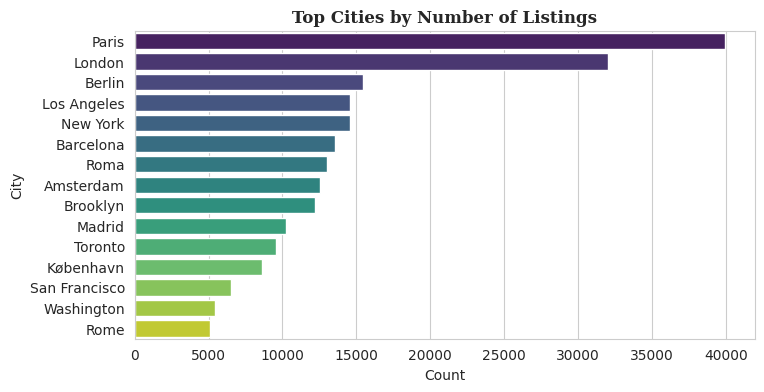

In [61]:
# Get the top 15 countries by count
top_cities = df['City'].value_counts().head(15)

# Create a bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x=top_cities.values, y=top_cities.index, palette=color_palette, hue=top_cities.index, dodge=False, legend=False)

# Set labels and title
plt.xlabel('Count')
plt.ylabel('City')
plt.title('Top Cities by Number of Listings', fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

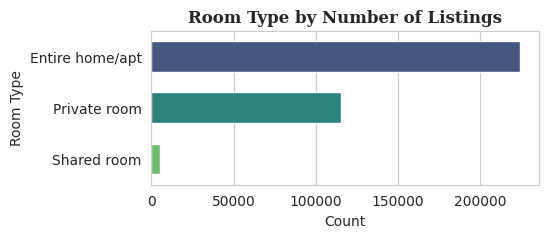

In [62]:
# Get the top 15 countries by count
room_types = df['Room Type'].value_counts()

# Create a bar plot
plt.figure(figsize=(5, 2))
sns.barplot(x=room_types.values, y=room_types.index, palette=color_palette, hue=room_types.index, dodge=False, legend=False, width=0.6)

# Set labels and title
plt.xlabel('Count')
plt.ylabel('Room Type')
plt.title('Room Type by Number of Listings', fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

## Price Analysis:

### Price Distribution: How is the price distributed across different categories (e.g., countries, cities, room types)?

<ipython-input-63-a9e6c90ff621>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Price', y='Country', data=df_top_countries, palette=color_palette,


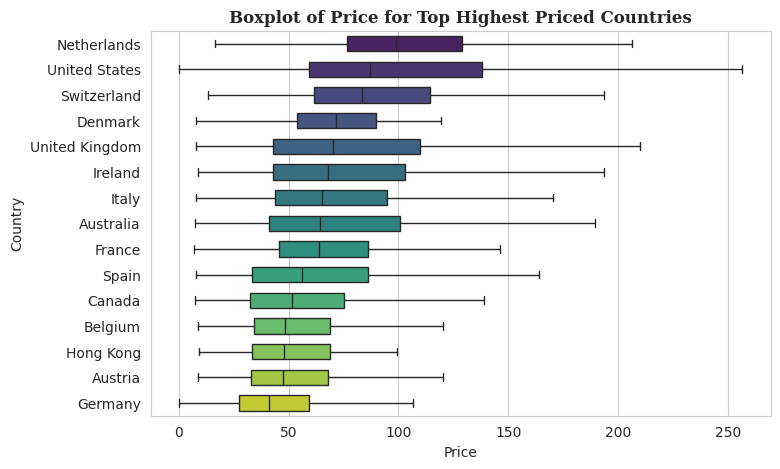

In [63]:
# Get the top 15 highest priced countries
top_countries = df.groupby('Country')['Price'].median().nlargest(15).index

# Filter the DataFrame to include only the top countries
df_top_countries = df[df['Country'].isin(top_countries)]

# Create a boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Price', y='Country', data=df_top_countries, palette=color_palette,
            order=df_top_countries.groupby('Country')['Price'].median().sort_values(ascending=False).index,
            showfliers = False, width=0.6)

# Set labels and title
plt.xlabel('Price')
plt.ylabel('Country')
plt.title('Boxplot of Price for Top Highest Priced Countries', fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

<ipython-input-64-65b802208808>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Price', y='City', data=df_top_cities, palette=color_palette,


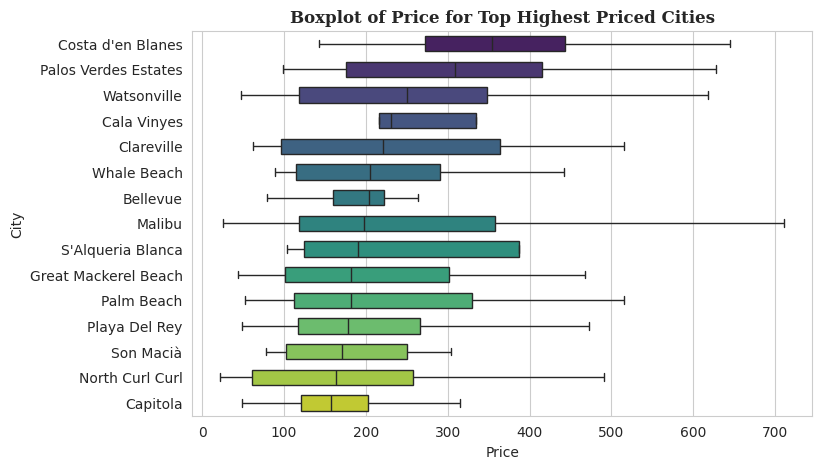

In [64]:
# Get the top 15 highest priced cities
top_cities = df.groupby('City')['Price'].median().nlargest(15).index

# Filter the DataFrame to include only the top countries
df_top_cities = df[df['City'].isin(top_cities)]

# Create a boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Price', y='City', data=df_top_cities, palette=color_palette,
            order=df_top_cities.groupby('City')['Price'].median().sort_values(ascending=False).index,
            showfliers = False, width=0.6)

# Set labels and title
plt.xlabel('Price')
plt.ylabel('City')
plt.title('Boxplot of Price for Top Highest Priced Cities', fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

<ipython-input-65-5c7d98e57851>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Price', y='Room Type', data=df, palette=color_palette,


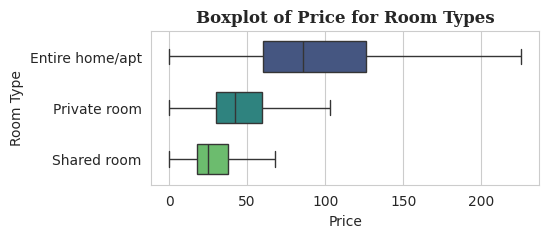

In [65]:
# Create a boxplot for Room Type
plt.figure(figsize=(5, 2))
sns.boxplot(x='Price', y='Room Type', data=df, palette=color_palette,
            order=['Entire home/apt', 'Private room', 'Shared room'],
            showfliers=False, width=0.6)

# Set labels and title
plt.xlabel('Price')
plt.ylabel('Room Type')
plt.title('Boxplot of Price for Room Types', fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

### Price Comparison: How does the price vary based on different factors (e.g., amenities, property type, cancellation policy)?

In [66]:
# Calculate correlation matrix for numeric columns
corr_matrix = df.corr()

# Get the top 10 correlated features with Price
top_correlated_features = corr_matrix['Price'].sort_values(ascending=False).head(16)[1:]

<ipython-input-66-ca8176aaed5b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


<ipython-input-67-4480e6cd4fa5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_correlated_features.values, y=top_correlated_features.index, palette='viridis', width=0.6)


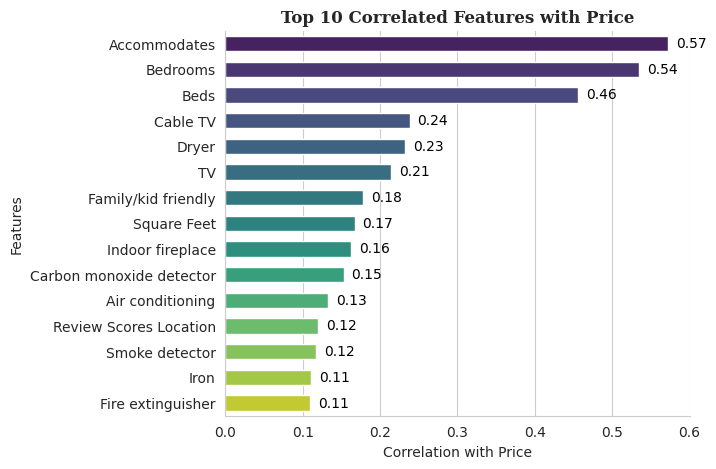

In [67]:
# Plotting
plt.figure(figsize=(6, 5))
sns.barplot(x=top_correlated_features.values, y=top_correlated_features.index, palette='viridis', width=0.6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Correlation with Price')
plt.ylabel('Features')
plt.title('Top 10 Correlated Features with Price', fontweight='bold', fontfamily='serif')
# Add annotations
for i, v in enumerate(top_correlated_features.values):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center', color='black')
plt.show()

<ipython-input-68-4fde19918cea>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Price', y='Accommodates', data=df_accommodates, palette=color_palette, vert=False,


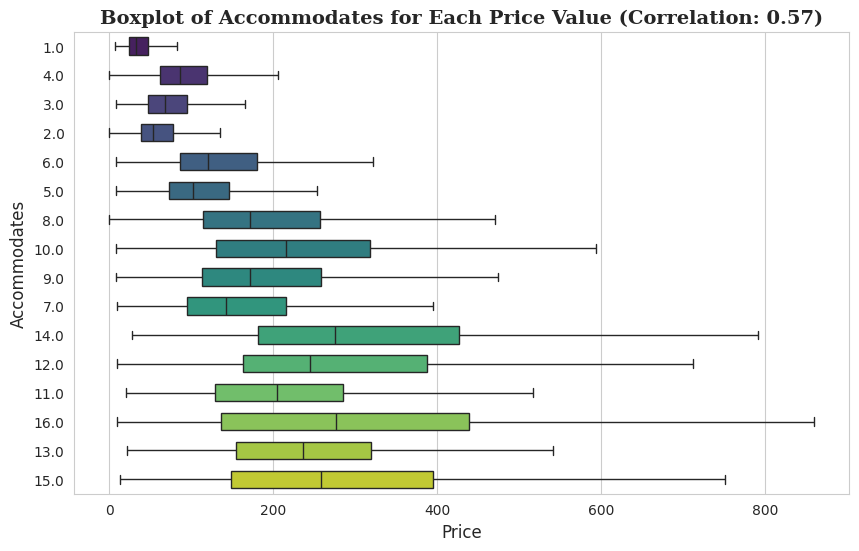

In [68]:
accommodates_corr = df['Price'].corr(df['Accommodates'])

# Create a new DataFrame with only Price and Beds columns
df_accommodates = df[['Price', 'Accommodates']].copy()

# Convert Beds column to strings
df_accommodates['Accommodates'] = df_accommodates['Accommodates'].astype(str)

# Create a boxplot for Room Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Price', y='Accommodates', data=df_accommodates, palette=color_palette, vert=False,
            showfliers=False, width=0.6)

# Set labels and title
plt.xlabel('Price', fontsize=12)
plt.ylabel('Accommodates', fontsize=12)
plt.title(f'Boxplot of Accommodates for Each Price Value (Correlation: {accommodates_corr:.2f})', fontsize=14, fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

<ipython-input-69-1e8e02dcead9>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Price', y='Beds', data=df_beds, palette=color_palette, vert=False,


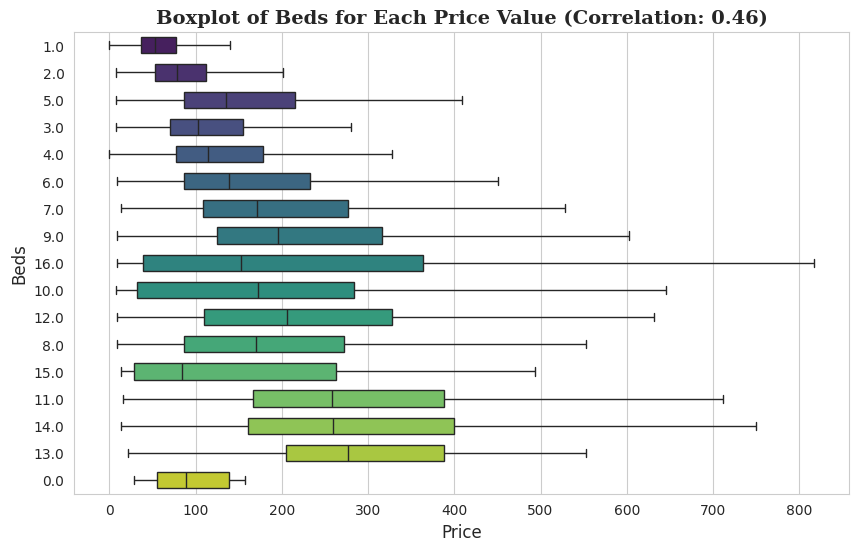

In [69]:
beds_corr = df['Price'].corr(df['Beds'])

# Create a new DataFrame with only Price and Beds columns
df_beds = df[['Price', 'Beds']].copy()

# Convert Beds column to strings
df_beds['Beds'] = df_beds['Beds'].astype(str)

# Create a boxplot for Room Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Price', y='Beds', data=df_beds, palette=color_palette, vert=False,
            showfliers=False, width=0.6)

# Set labels and title
plt.xlabel('Price', fontsize=12)
plt.ylabel('Beds', fontsize=12)
plt.title(f'Boxplot of Beds for Each Price Value (Correlation: {beds_corr:.2f})', fontsize=14, fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

<ipython-input-70-70433f0b7585>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Price', y='Cable TV', data=df_cabletv, palette=color_palette,


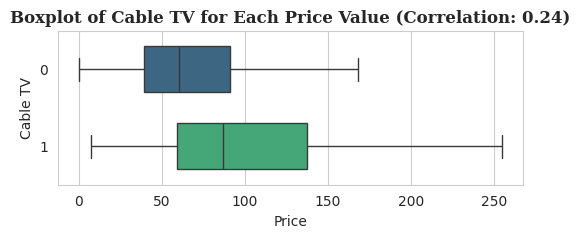

In [70]:
cabletv_corr = df['Price'].corr(df['Cable TV'])

# Create a new DataFrame with only Price and Cable TV columns
df_cabletv = df[['Price', 'Cable TV']].copy()

# Convert Cable TV column to strings
df_cabletv['Cable TV'] = df_cabletv['Cable TV'].astype(str)

# Create a boxplot for Cable TV
plt.figure(figsize=(6, 2))
sns.boxplot(x='Price', y='Cable TV', data=df_cabletv, palette=color_palette,
            showfliers=False, width=0.6)

# Set labels and title
plt.xlabel('Price')
plt.ylabel('Cable TV')
plt.title(f'Boxplot of Cable TV for Each Price Value (Correlation: {cabletv_corr:.2f})', fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

<ipython-input-71-15b527292d17>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Price', y='Dryer', data=df_dryer, palette=color_palette,


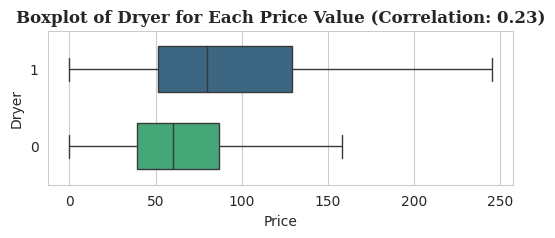

In [71]:
dryer_corr = df['Price'].corr(df['Dryer'])

# Create a new DataFrame with only Price and Dryer columns
df_dryer = df[['Price', 'Dryer']].copy()

# Convert Dryer column to strings
df_dryer['Dryer'] = df_dryer['Dryer'].astype(str)

# Create a boxplot for Dryer
plt.figure(figsize=(6, 2))
sns.boxplot(x='Price', y='Dryer', data=df_dryer, palette=color_palette,
            showfliers=False, width=0.6)

# Set labels and title
plt.xlabel('Price')
plt.ylabel('Dryer')
plt.title(f'Boxplot of Dryer for Each Price Value (Correlation: {dryer_corr:.2f})', fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

<ipython-input-72-b777cbd8c5c3>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Price', y='TV', data=df_tv, palette=color_palette,


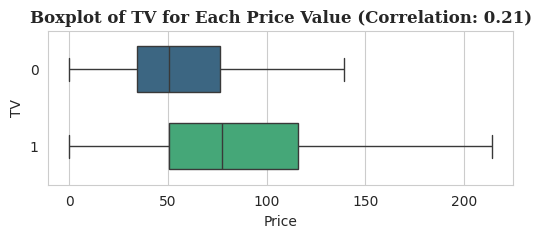

In [72]:
tv_corr = df['Price'].corr(df['TV'])

# Create a new DataFrame with only Price and TV columns
df_tv = df[['Price', 'TV']].copy()

# Convert TV column to strings
df_tv['TV'] = df_tv['TV'].astype(str)

# Create a boxplot for TV
plt.figure(figsize=(6, 2))
sns.boxplot(x='Price', y='TV', data=df_tv, palette=color_palette,
            showfliers=False, width=0.6)

# Set labels and title
plt.xlabel('Price')
plt.ylabel('TV')
plt.title(f'Boxplot of TV for Each Price Value (Correlation: {tv_corr:.2f})', fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

<ipython-input-73-43e0497b919a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Price', y='Family/kid friendly', data=df_famkid, palette=color_palette,


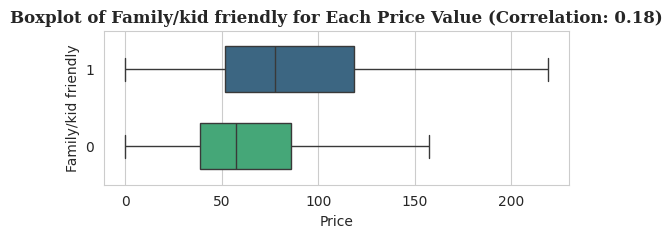

In [73]:
famkid_corr = df['Price'].corr(df['Family/kid friendly'])

# Create a new DataFrame with only Price and TV columns
df_famkid = df[['Price', 'Family/kid friendly']].copy()

# Convert TV column to strings
df_famkid['Family/kid friendly'] = df_famkid['Family/kid friendly'].astype(str)

# Create a boxplot for TV
plt.figure(figsize=(6, 2))
sns.boxplot(x='Price', y='Family/kid friendly', data=df_famkid, palette=color_palette,
            showfliers=False, width=0.6)

# Set labels and title
plt.xlabel('Price')
plt.ylabel('Family/kid friendly')
plt.title(f'Boxplot of Family/kid friendly for Each Price Value (Correlation: {famkid_corr:.2f})', fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

<ipython-input-74-57ee2ecd19ed>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Price', y='Indoor fireplace', data=df_fireplace, palette=color_palette,


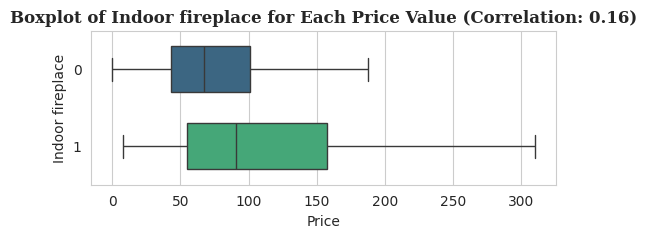

In [74]:
fireplace_corr = df['Price'].corr(df['Indoor fireplace'])

# Create a new DataFrame with only Price and TV columns
df_fireplace = df[['Price', 'Indoor fireplace']].copy()

# Convert TV column to strings
df_fireplace['Indoor fireplace'] = df_fireplace['Indoor fireplace'].astype(str)

# Create a boxplot for TV
plt.figure(figsize=(6, 2))
sns.boxplot(x='Price', y='Indoor fireplace', data=df_fireplace, palette=color_palette,
            showfliers=False, width=0.6)

# Set labels and title
plt.xlabel('Price')
plt.ylabel('Indoor fireplace')
plt.title(f'Boxplot of Indoor fireplace for Each Price Value (Correlation: {fireplace_corr:.2f})', fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

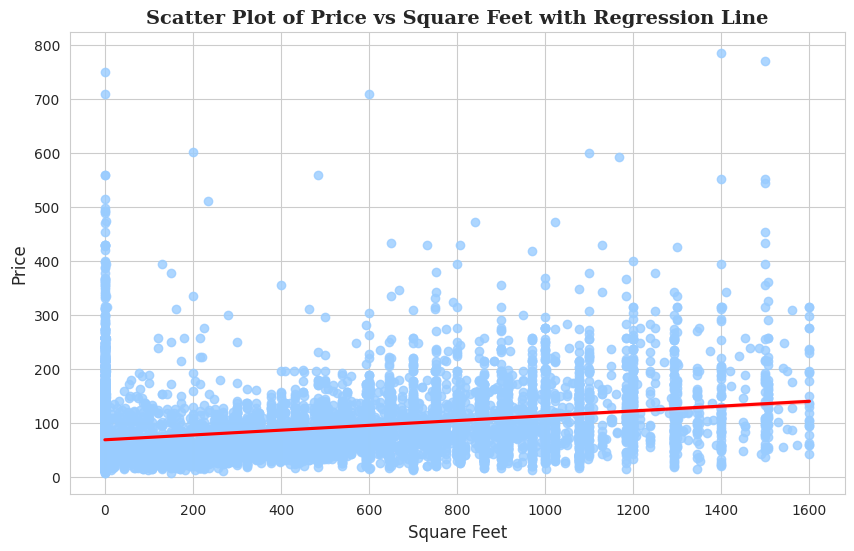

In [75]:
# Remove outliers from Square Feet variable
temp_df = df[df['Square Feet'].between(df['Square Feet'].quantile(0.05), df['Square Feet'].quantile(0.95))]

# Create a scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=temp_df, x='Square Feet', y='Price', scatter_kws={'color': (0.6, 0.8, 1), 'alpha': 0.8}, line_kws={'color': 'red'})

# Set labels and title
plt.xlabel('Square Feet', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Scatter Plot of Price vs Square Feet with Regression Line', fontsize=14, fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

<ipython-input-76-aebbe8269b46>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Price', y='Air conditioning', data=df_ac, palette=color_palette,


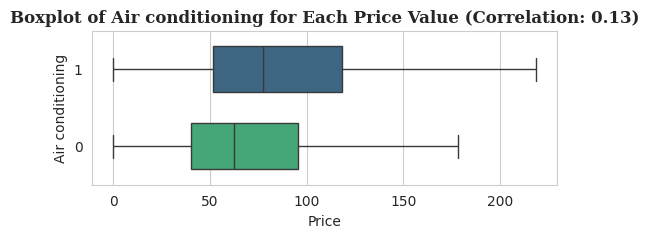

In [76]:
ac_corr = df['Price'].corr(df['Air conditioning'])

# Create a new DataFrame with only Price and TV columns
df_ac = df[['Price', 'Air conditioning']].copy()

# Convert TV column to strings
df_ac['Air conditioning'] = df_ac['Air conditioning'].astype(str)

# Create a boxplot for TV
plt.figure(figsize=(6, 2))
sns.boxplot(x='Price', y='Air conditioning', data=df_ac, palette=color_palette,
            showfliers=False, width=0.6)

# Set labels and title
plt.xlabel('Price')
plt.ylabel('Air conditioning')
plt.title(f'Boxplot of Air conditioning for Each Price Value (Correlation: {ac_corr:.2f})', fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

# Data Pre-Processing

## Pipeline for Numerical Features

In [77]:
# Select numerical columns only
numerical_attribs = ['Accommodates', 'Bedrooms', 'Beds', 'Number of Reviews', 'Host Since Days',
    'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
    'Review Scores Communication', 'Review Scores Location', 'Review Scores Value']

#df_num = df.select_dtypes(include=[np.number])
numerical_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

## Pipeline for Categorical Features


In [78]:
categorical_attribs = ['Host Response Time']
all_categorical_attribs = ['Host Response Time', 'Neighbourhood Cleansed', 'City', 'Country', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy']

# Define the custom order for Host Response Time
custom_order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']

# Define the categorical pipeline for Host Response Time
categorical_ordinal_pipeline = Pipeline([
    ('ordinal_encoder', OrdinalEncoder(categories=[custom_order]))
])

categorical_one_hot_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(drop='first'))  # Drop first category to avoid multicollinearity
])

## Combined Pipeline for All Features

In [79]:
other_features = ['Neighbourhood Cleansed', 'City', 'Country', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy', 'Host Identity Verified', 'Host Is Superhost', 'TV', 'Wireless Internet', 'Kitchen', 'Heating', 'Family/kid friendly', 'Washer', 'Smoke detector', 'Fire extinguisher', 'Essentials', 'Cable TV', 'Internet', 'Dryer', 'First aid kit', 'Safety card', 'Shampoo', 'Hangers', 'Laptop friendly workspace', 'Air conditioning', 'Breakfast', 'Free parking on premises', 'Elevator in building', 'Buzzer/wireless intercom', 'Hair dryer', 'Private living room', 'Iron', 'Wheelchair accessible', 'Hot tub', 'Carbon monoxide detector', '24-hour check-in', 'Pets live on this property', 'Dog(s)', 'Gym', 'Lock on bedroom door', 'Private entrance', 'Indoor fireplace', 'Smoking allowed', 'Pets allowed', 'Cat(s)', 'Self Check-In', 'Doorman Entry', 'Suitable for events', 'Pool', 'Lockbox', 'Bathtub', 'Room-darkening shades', 'Game console', 'Doorman', 'High chair', 'Pack ’n Play/travel crib', 'Keypad', 'Other pet(s)', 'Smartlock', 'Price']

In [80]:
# Combined Pipeline for all Features

preprocessing_pipeline_1 = ColumnTransformer([
        ("categorical", categorical_ordinal_pipeline,  ['Host Response Time']),
        ("numerical", numerical_pipeline, numerical_attribs),
    ])

preprocessing_pipeline_2 = ColumnTransformer([
    ("categorical_ordinal", categorical_ordinal_pipeline, ['Host Response Time']),
    ("categorical_one_hot", categorical_one_hot_pipeline, [col for col in all_categorical_attribs if col != 'Host Response Time']),
    ("numerical", numerical_pipeline, numerical_attribs),
])

label = ["Price"]

In [81]:
preprocessed_data_1 = preprocessing_pipeline_1.fit_transform(df)
preprocessed_data_1.shape

(345467, 13)

In [82]:
# Apply the preprocessing pipeline to the entire DataFrame
preprocessed_data_1 = preprocessing_pipeline_1.fit_transform(df)

# If you want to preserve the column names, you can convert the preprocessed data into a DataFrame
preprocessed_df_1 = pd.DataFrame(preprocessed_data_1, columns=['Host Response Time'] + numerical_attribs)

preprocessed_df_1.head(3)

,Host Response Time,Accommodates,Bedrooms,Beds,Number of Reviews,Host Since Days,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value
0,0.0,-1.147118,-0.377517,-0.630869,0.253841,-1.216365,-0.578003,-0.621373,-1.285333,-0.953651,-0.991307,-0.590877,-0.355714
1,1.0,0.363970,0.779918,0.076235,-0.606879,1.061039,0.844171,0.559670,0.654651,0.427011,0.407755,0.660747,0.756340
2,0.0,-0.139726,-0.377517,-0.630869,0.142781,0.165737,0.251598,0.559670,0.654651,-0.953651,-0.991307,-0.590877,-0.355714


In [83]:
# Apply the preprocessing pipeline to the entire DataFrame
preprocessed_data_2 = preprocessing_pipeline_2.fit_transform(df)

# Get the column names for ordinal encoded 'Host Response Time'
ordinal_encoded_cols = ['Host Response Time']  # Replace 'Host_Response_Time_encoded' with the actual name

# Get the column names for one-hot encoded categorical features (excluding 'Host Response Time')
one_hot_encoded_cols = preprocessing_pipeline_2.named_transformers_['categorical_one_hot'].named_steps['one_hot_encoder'] \
    .get_feature_names_out(
        input_features=[col for col in all_categorical_attribs if col != 'Host Response Time']
    )

# Combine all column names
preprocessed_columns = ordinal_encoded_cols + list(one_hot_encoded_cols) + numerical_attribs

In [84]:
# Convert the sparse matrix to a DataFrame
preprocessed_df_2 = pd.DataFrame.sparse.from_spmatrix(preprocessed_data_2, columns=preprocessed_columns)

preprocessed_df_2.head(3)

,Host Response Time,Neighbourhood Cleansed_Abbeyhill,Neighbourhood Cleansed_Abrantes,Neighbourhood Cleansed_Acacias,Neighbourhood Cleansed_Adams,Neighbourhood Cleansed_Adams Point,Neighbourhood Cleansed_Adams-Normandie,Neighbourhood Cleansed_Adelfas,Neighbourhood Cleansed_Adlershof,Neighbourhood Cleansed_Agincourt North,...,Beds,Number of Reviews,Host Since Days,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.630869,0.253841,-1.216365,-0.578003,-0.621373,-1.285333,-0.953651,-0.991307,-0.590877,-0.355714
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.076235,-0.606879,1.061039,0.844171,0.559670,0.654651,0.427011,0.407755,0.660747,0.756340
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.630869,0.142781,0.165737,0.251598,0.559670,0.654651,-0.953651,-0.991307,-0.590877,-0.355714


In [85]:
combined_df_1 = pd.concat([preprocessed_df_1, df[[col for col in all_categorical_attribs if col not in ['Host Response Time']]].reset_index(drop=True), df['Price'].reset_index(drop=True)], axis=1)
combined_df_1.head(3)

,Host Response Time,Accommodates,Bedrooms,Beds,Number of Reviews,Host Since Days,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,...,Review Scores Location,Review Scores Value,Neighbourhood Cleansed,City,Country,Property Type,Room Type,Bed Type,Cancellation Policy,Price
0,0.0,-1.147118,-0.377517,-0.630869,0.253841,-1.216365,-0.578003,-0.621373,-1.285333,-0.953651,...,-0.590877,-0.355714,Williamsburg,Brooklyn,United States,Loft,Private room,Real Bed,flexible,41.08
1,1.0,0.363970,0.779918,0.076235,-0.606879,1.061039,0.844171,0.559670,0.654651,0.427011,...,0.660747,0.756340,BYRON SHIRE COUNCIL,Byron Bay,Australia,House,Entire home/apt,Real Bed,strict,104.00
2,0.0,-0.139726,-0.377517,-0.630869,0.142781,0.165737,0.251598,0.559670,0.654651,-0.953651,...,-0.590877,-0.355714,BYRON SHIRE COUNCIL,Suffolk Park,Australia,Apartment,Entire home/apt,Real Bed,strict,65.00


In [86]:
combined_df_2 = pd.concat([preprocessed_df_2, df[[col for col in other_features if col not in ['Neighbourhood Cleansed', 'City', 'Country', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy', 'Price']]].reset_index(drop=True), df['Price'].reset_index(drop=True)], axis=1)
combined_df_2.head(3)

,Host Response Time,Neighbourhood Cleansed_Abbeyhill,Neighbourhood Cleansed_Abrantes,Neighbourhood Cleansed_Acacias,Neighbourhood Cleansed_Adams,Neighbourhood Cleansed_Adams Point,Neighbourhood Cleansed_Adams-Normandie,Neighbourhood Cleansed_Adelfas,Neighbourhood Cleansed_Adlershof,Neighbourhood Cleansed_Agincourt North,...,Bathtub,Room-darkening shades,Game console,Doorman,High chair,Pack ’n Play/travel crib,Keypad,Other pet(s),Smartlock,Price
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,41.08
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,104.00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,65.00


# Model Training

## Split Dataset into Train and Test sets

In [87]:
# Define X and y
X = combined_df_1.drop(columns=['Price'])  # Assuming 'Price' is the target variable
y = combined_df_1['Price']

# Split the data into train and test sets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42)  # Adjust test_size as needed

# Optionally, you can print the shapes of the train and test sets to verify the split
print("X_train shape:", X_train_1.shape)
print("y_train shape:", y_train_1.shape)
print("X_test shape:", X_test_1.shape)
print("y_test shape:", y_test_1.shape)

X_train shape: (276373, 20)
y_train shape: (276373,)
X_test shape: (69094, 20)
y_test shape: (69094,)


In [88]:
# Define X and y
X_2 = combined_df_2.drop(columns=['Price'])  # Assuming 'Price' is the target variable
y_2 = combined_df_2['Price']

# Split the data into train and test sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)  # Adjust test_size as needed

# Optionally, you can print the shapes of the train and test sets to verify the split
print("X_train shape:", X_train_2.shape)
print("y_train shape:", y_train_2.shape)
print("X_test shape:", X_test_2.shape)
print("y_test shape:", y_test_2.shape)

X_train shape: (276373, 3071)
y_train shape: (276373,)
X_test shape: (69094, 3071)
y_test shape: (69094,)


## CatBoostRegressor without Encoded Features

In [89]:
# Define the CatBoost model
catboost_model_1 = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='RMSE')

# Specify the indices of the categorical features
cat_features_indices = [13, 14, 15, 16, 17, 18, 19]

# Train the model on the training data, specifying the categorical features
catboost_model_1.fit(X_train_1, y_train_1, cat_features=cat_features_indices, verbose=100)

# Predict on the testing data
y_pred_catboost_1 = catboost_model_1.predict(X_test_1)

# Calculate RMSE
rmse_catboost_1 = mean_squared_error(y_test_1, y_pred_catboost_1, squared=False)
print("RMSE for Catboost without encoded features:", rmse_catboost_1)

0:	learn: 69.1313870	total: 115ms	remaining: 11.3s
99:	learn: 43.7919690	total: 3.64s	remaining: 0us
RMSE for Catboost without encoded features: 43.37069492390436


## XGBRegressor with Encoded Features

In [90]:
# Convert sparse matrix to dense array
X_train_2_dense = X_train_2.values

# Define the XGBoost model
xgb_model_2 = XGBRegressor()

# Train the XGBoost model
xgb_model_2.fit(X_train_2_dense, y_train_2)

# Predict on the testing data
y_pred_2 = xgb_model_2.predict(X_test_2)

# Calculate RMSE for the second dataset
rmse_xgb_2 = mean_squared_error(y_test_2, y_pred_2, squared=False)
print("RMSE for XGBoost with encoded features:", rmse_xgb_2)

RMSE for XGBoost with encoded features: 41.888514977600124


## LightBGM with Encoded Features

In [91]:
def clean_feature_names(df):
    # Make a copy of the DataFrame to avoid modifying the original
    df_cleaned = df.copy()

    # Define a regular expression pattern to match special characters
    pattern = r"[^\w\s]"

    # Iterate through column names
    for col in df_cleaned.columns:
        # Check if the column name contains special characters
        if re.search(pattern, col):
            # Replace special characters with underscores
            new_col = re.sub(pattern, '_', col)
            # Rename the column
            df_cleaned.rename(columns={col: new_col}, inplace=True)
    return df_cleaned

# Clean feature names in a copy of X_train_2
X_train_2_cleaned = clean_feature_names(X_train_2)

In [92]:
# Define the LightGBM model
lgbm_model_2 = LGBMRegressor()

# Train the LightGBM model
lgbm_model_2.fit(X_train_2_cleaned, y_train_2)

# Predict on the testing data
y_pred_lgbm_2 = lgbm_model_2.predict(X_test_2)

# Calculate RMSE for the second dataset
rmse_lgbm_2 = mean_squared_error(y_test_2, y_pred_lgbm_2, squared=False)
print("RMSE for LightGBM with encoded features:", rmse_lgbm_2)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.093783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4412
[LightGBM] [Info] Number of data points in the train set: 276373, number of used features: 1879
[LightGBM] [Info] Start training from score 86.948961
RMSE for LightGBM with encoded features: 42.34405938585943


## CatBooost with Encoded Features

In [93]:
# Define the CatBoost model
catboost_model_2 = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='RMSE')

# Train the model on the training data, specifying the categorical features
catboost_model_2.fit(X_train_2, y_train_2, verbose=100)

# Predict on the testing data
y_pred_catboost_2 = catboost_model_2.predict(X_test_2)

# Calculate RMSE
rmse_catboost_2 = mean_squared_error(y_test_2, y_pred_catboost_2, squared=False)
print("RMSE for CatBoost with encoded features:", rmse_catboost_2)

0:	learn: 69.2989736	total: 28.9ms	remaining: 2.86s
99:	learn: 44.9425873	total: 2.26s	remaining: 0us
RMSE for CatBoost with encoded features: 44.730057818999576


## Combined Cross Validation

In [ ]:
# Define the models
models = {
    "CatBoost without encoded features": catboost_model_1,
    "XGBoost with encoded features": xgb_model_2,
    "LightGBM with encoded features": lgbm_model_2,
    "CatBoost with encoded features": catboost_model_2
}

# Define the X and y for each model
X_train = {
    "CatBoost without encoded features": X_train_1,
    "XGBoost with encoded features": X_train_2,
    "LightGBM with encoded features": X_train_2_cleaned,
    "CatBoost with encoded features": X_train_2
}

y_train = {
    "CatBoost without encoded features": y_train_1,
    "XGBoost with encoded features": y_train_2,
    "LightGBM with encoded features": y_train_2,
    "CatBoost with encoded features": y_train_2
}

# Specify categorical features indices for CatBoost model 1
cat_features_indices_1 = [13, 14, 15, 16, 17, 18, 19]

# Perform 5-fold cross-validation for each model
cv_scores = {}
for name, model in models.items():
    if name == "CatBoost without encoded features":
        scores = cross_val_score(model, X_train[name], y_train[name], cv=5, scoring='neg_root_mean_squared_error',
                                 fit_params={'cat_features': cat_features_indices_1, 'verbose': 100})
    else:
        scores = cross_val_score(model, X_train[name], y_train[name], cv=5, scoring='neg_root_mean_squared_error')
    cv_scores[name] = -scores  # Convert negative RMSE scores to positive
    print(f"Mean RMSE for {name}: {np.mean(cv_scores[name])}")

<ipython-input-101-3305b8b38c2d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(y=list(cv_scores.keys()), x=[np.mean(score) for score in cv_scores.values()], palette='viridis')


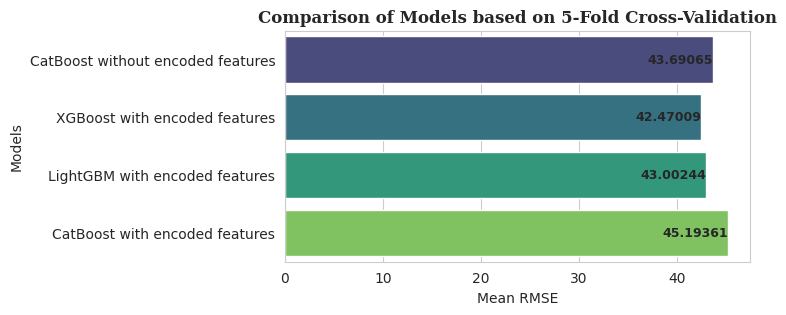

In [101]:
# Create a bar graph using Seaborn
plt.figure(figsize=(6, 3))
barplot = sns.barplot(y=list(cv_scores.keys()), x=[np.mean(score) for score in cv_scores.values()], palette='viridis')

# Add values on the bars
for index, value in enumerate([np.mean(score) for score in cv_scores.values()]):
    # Adjust horizontal alignment based on bar position
    ha = 'left' if value < 0 else 'right'
    # Add extra space between value and bar end
    x_offset = 0.005 if value < 0 else -0.005
    barplot.text(value + x_offset, index, str(round(value, 5)), ha=ha, va='center', fontsize=9, fontweight='bold')

plt.title("Comparison of Models based on 5-Fold Cross-Validation", fontweight='bold', fontfamily='serif')
plt.xlabel('Mean RMSE')
plt.ylabel('Models')
plt.show()

## Hyperparameter Tuning

In [102]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to be tuned
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'tree_method': 'gpu_hist'
    }

    # Initialize XGBRegressor with current set of hyperparameters
    xgb_model = XGBRegressor(**params)

    # Fit the model on training data
    xgb_model.fit(X_train_2, y_train_2)

    # Predict on the validation data
    y_pred = xgb_model.predict(X_test_2)

    # Calculate RMSE
    rmse = mean_squared_error(y_test_2, y_pred, squared=False)

    return rmse

# Create study object and optimize hyperparameters
#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=100)

# Get best hyperparameters
#best_params = study.best_params
#best_rmse = study.best_value

#print("Best RMSE:", best_rmse)
#print("Best hyperparameters:", best_params)

[I 2024-03-28 07:44:57,952] A new study created in memory with name: no-name-74f55035-6ffd-48f9-b3b9-2bd7d89b7910
<ipython-input-102-411b4bb76cd5>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:45:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:45:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter

Best RMSE: 39.74362663343108
Best hyperparameters: {'n_estimators': 794, 'max_depth': 10, 'learning_rate': 0.08548661891255152, 'subsample': 0.7318900020890863, 'colsample_bytree': 0.8986132947552056, 'gamma': 0.9366108890026331, 'reg_alpha': 6.347249921400984, 'reg_lambda': 7.202729761977883}


In [103]:
#print("Best RMSE:", best_rmse)
#print("Best hyperparameters:", best_params)

Best RMSE: 39.74362663343108
Best hyperparameters: {'n_estimators': 794, 'max_depth': 10, 'learning_rate': 0.08548661891255152, 'subsample': 0.7318900020890863, 'colsample_bytree': 0.8986132947552056, 'gamma': 0.9366108890026331, 'reg_alpha': 6.347249921400984, 'reg_lambda': 7.202729761977883}


## Saving Model with Hyperparameters

Best RMSE: 39.74362663343108
Best hyperparameters: {'n_estimators': 794, 'max_depth': 10, 'learning_rate': 0.08548661891255152, 'subsample': 0.7318900020890863, 'colsample_bytree': 0.8986132947552056, 'gamma': 0.9366108890026331, 'reg_alpha': 6.347249921400984, 'reg_lambda': 7.202729761977883}

In [94]:
# Best hyperparameters
best_hyperparameters = {'n_estimators': 794,
                        'max_depth': 10,
                        'learning_rate': 0.08548661891255152,
                        'subsample': 0.7318900020890863,
                        'colsample_bytree': 0.8986132947552056,
                        'gamma': 0.9366108890026331,
                        'reg_alpha': 6.347249921400984,
                        'reg_lambda': 7.202729761977883}

# Define the XGBoost model with best hyperparameters
xgb_model = XGBRegressor(**best_hyperparameters)

# Convert sparse matrix to dense array for training
X_train_2_dense = X_train_2.values

# Train the XGBoost model
xgb_model.fit(X_train_2_dense, y_train_2)

# Save the trained model using pickle
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

print("XGBoost model saved successfully.")

XGBoost model saved successfully.


In [95]:
# Predict on the testing data
y_pred_2 = xgb_model.predict(X_test_2)

# Calculate RMSE for the second dataset
rmse_xgb_2 = mean_squared_error(y_test_2, y_pred_2, squared=False)
print("RMSE for XGBoost with encoded features:", rmse_xgb_2)

RMSE for XGBoost with encoded features: 39.83427656511128


The RMSE value obtained for predicting the Price column using XGBoost with encoded features is approximately 39.83 pounds. This metric signifies the average difference between the actual Price values and the predictions made by the model.

To interpret this result effectively, let's consider the descriptive statistics of the Price column:
- The mean Price value is approximately 86.99 pounds, indicating the average price of items in the dataset.
- The standard deviation (std) of Price is approximately 72.51 pounds, representing the dispersion of Price values around the mean.
- The minimum and maximum Price values are 0 and 999 pounds, respectively, showcasing the range of prices observed in the dataset.
- Additionally, the 25th, 50th (median), and 75th percentiles of Price are 43.00, 68.73, and 103.20 pounds, respectively, providing insights into the distribution of Price values.

Comparing the RMSE value with these statistics, we observe that the RMSE of approximately 39.83 pounds represents a considerable portion of the standard deviation (approximately 55%). This indicates that the model's predictions have a moderate level of error relative to the variability in Price values.

Furthermore, considering the quartiles of the Price distribution, the RMSE value falls within the interquartile range (IQR) of approximately 60.20 pounds (between the 25th and 75th percentiles). This suggests that the model's predictions generally align well with the central tendency of the Price values.

Overall, while the RMSE value of 39.83 pounds indicates that the model's predictions are relatively close to the actual Price values on average, there is still room for improvement to enhance the model's accuracy and reduce prediction errors further.